In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os

In [2]:
from build_real import GraphDomain 

def Load_data(sc = 'NULL'):
    sc = "Datasets/IDPCDU_Edges/set1/"
    Tasks = os.listdir(sc)
    Tasks.sort()
    MAX_DIM = 0
    NUM_TASK = 2

    for i in range(2):
        path = sc + Tasks[i] 
        Tasks[i] = GraphDomain(path,name=Tasks[i])
        MAX_DIM = max(MAX_DIM, Tasks[i].NUM_DOMAIN)

    return Tasks[:2], NUM_TASK, MAX_DIM


In [3]:
Tasks, NUM_TASK, MAX_DIM = Load_data()
def GeneratorIndiv(dims=MAX_DIM):
    indiv = np.random.permutation(range(1,dims+1))

    fac_cost = []
    for task in Tasks:
        fac_cost.append(task.Cost(indiv))
    
    return indiv, fac_cost

In [4]:
def Generate_Eval(sizePop, d = MAX_DIM):
    population = []
    pop_cost = []
    for i in range(sizePop):
        pi, f_cost = GeneratorIndiv(d)
        population.append(pi)
        pop_cost.append(f_cost)
    population,pop_cost = np.asarray(population),np.asarray(pop_cost)
    rank = np.argsort(pop_cost,axis = 0) + 1
#     skill_factor = np.argmin(rank,axis = 1)+1
#     fitness = 1/np.min(rank,axis = 1) 
#     return population,pop_cost,rank,skill_factor,fitness
    return population,pop_cost,rank

In [5]:
def heSo(n,m,TH=0.4):
    # a1 + b1 = 1
    # a1*m+b1 = TH
    # a2*m + b2= TH
    # a2*n + b2 = 0
    a1 = (1-TH)/(1-m)
    b1 = 1 - a1
    a2 = TH/(m-n)
    b2 = (TH-a2*m)
    return a1,b1,a2,b2

In [6]:
def fm(a1,b1,a2,b2,n,m,r,TH=0.4):
    if r >= 1 and r <m:
        return a1*r+b1
    elif r == m:
        return TH
    elif r >= m+1:
        return a2*r+b2

In [7]:
def abilitiVector(rank,TH,n,m):
    a1,b1,a2,b2 = heSo(n,m,TH)
    abiVector =[]
    for x in range(len(rank)):
        df =[]
        for item in rank[x]:
            df.append(fm(a1,b1,a2,b2,n,m,item,TH))
        abiVector.append(df)
    return np.array(abiVector)

In [8]:
import math

def cross_SBX(p1, p2, nc = 2):
    u = np.random.random_sample()
    if u < 0.5:
        beta = math.pow(2*u, 1/(nc+1))
    else:
        beta = math.pow(0.5/(1-u), 1/(nc+1))

    c1 = 0.5*((1+beta)*p1 + (1-beta)*p2)
    c2 = 0.5*((1-beta)*p1 + (1+beta)*p2)

    return c1, c2

In [9]:
def Diff_Mutation(y1,y2,y3,y4):
    F = np.random.random_sample()
    return y1 + F * (y4 - y1 + y2 - y3)

In [10]:
def Poly_Mutation(p,nm = 20):
    u = np.random.random_sample()
    if u <= 0.5:
        phi = np.power(2*u,1/(nm+1)) -1
        return p + phi*p
    else:
        phi = 1 - np.power(2-2*u,1/(nm+1))
        return p + phi*(1-p)

In [11]:
def mutation(individual, e = 0.15):
    n = len(individual)
    res = np.array(individual)

    index1 = np.random.randint(n)
    index2 = np.random.randint(n)
    while index1 == index2:
        index2 = np.random.randint(n)

    res[index1] -= e
    res[index2] += e

    return res

In [12]:
def cross_pmx(p1, p2):
    n = len(p1)
    l = int(n/3)
    
    index1 = np.random.randint(l)
    index2 = np.random.randint(l+l, 3*l)
    # while index1 == index2:
    #    index2 = np.random.randint(1, n-1)

    # if index1 > index2:
    #     temp = index1
    #     index1 = index2
    #     index2 = temp

    o1 = np.array(p2)
    o2 = np.array(p1)

    pos1 = np.full(n+1, -1, dtype=int)
    pos2 = np.full(n+1, -1, dtype=int)
    for i in range(index1, index2+1):
        pos1[o1[i]] = i
        pos2[o2[i]] = i
        
    for i in range(n):
        if index1 <= i and i <= index2: continue

        id1 = i
        while True:
            if pos1[p1[id1]] == -1:
                o1[i] = p1[id1]
                break
            id1 = pos1[p1[id1]]
        
        id2 = i
        while True:
            if pos2[p2[id2]] == -1:
                o2[i] = p2[id2]
                break
            id2 = pos2[p2[id2]]
    
    return o1, o2

def paradox_mutation(indiv):
    n = len(indiv)
    index1 = 0
    index2 = np.random.randint(1, n-1)

    if index1 > index2:
        temp = index1
        index1 = index2
        index2 = temp

    while index1 < index2:
        temp = indiv[index1]
        indiv[index1] = indiv[index2]
        indiv[index2] = temp
        index1 += 1
        index2 -= 1

    return indiv


def mutation_swap(individual):
    n = len(individual)
    res = np.array(individual)

    index1 = np.random.randint(5)
    index2 = np.random.randint(n)
    while index1 == index2:
        index2 = np.random.randint(n)

    temp = res[index1]
    res[index1] = res[index2]
    res[index2] = temp

    return res

In [13]:
# def cross_pmx(p1, p2):
#     n = p1.shape[0]
#     # min = int(n/4)
#     # max = int(n - n/4)

#     if n > 13:
#         cross = 10
#     else:
#         cross = 0
#     #if(np.random.random_sample() < 0.01): cross = 25
    
#     index1 = np.random.randint(1, n-cross)
#     index2 = index1 + cross
#     #while index1 == index2:
#     #    index2 = np.random.randint(1, n-1)
   
#     # if index1 > index2:
#     #     temp = index1
#     #     index1 = index2
#     #     index2 = temp

#     #print(index1, index2)

#     o1 = np.array(p2)
#     o2 = np.array(p1)

#     pos1 = np.full(n+1, -1, dtype=int)
#     pos2 = np.full(n+1, -1, dtype=int)
#     for i in range(index1, index2+1):
#         pos1[o1[i]] = i
#         pos2[o2[i]] = i
        
#     for i in range(n):
#         if index1 <= i and i <= index2: continue

#         id1 = i
#         while True:
#             if pos1[p1[id1]] == -1:
#                 o1[i] = p1[id1]
#                 break
#             id1 = pos1[p1[id1]]
        
#         id2 = i
#         while True:
#             if pos2[p2[id2]] == -1:
#                 o2[i] = p2[id2]
#                 break
#             id2 = pos2[p2[id2]]
    
#     return o1, o2
# def mutation_swap(individual):
#     n = len(individual)
#     res = np.array(individual)

#     index1 = np.random.randint(n)
#     index2 = np.random.randint(n)
#     while index1 == index2:
#         index2 = np.random.randint(n)

#     temp = res[index1]
#     res[index1] = res[index2]
#     res[index2] = temp

#     return res

In [14]:
# def paradox_mutation(indiv):
#     n = len(indiv)
#     index1 = np.random.randint(1, n-1)
#     index2 = np.random.randint(1, n-1)
#     while index1 == index2:
#         index2 = np.random.randint(1, n-1)
   
#     if index1 > index2:
#         temp = index1
#         index1 = index2
#         index2 = temp
#     while index1 < index2:
#         temp = indiv[index1]
#         indiv[index1] = indiv[index2]
#         indiv[index2] = temp
#         index1 += 1
#         index2 -= 1

#     return indiv

In [40]:
def Offspring_Generation(pop,abiVector,task,Pa,Pb,m):
    n = pop.shape[0]
    x_star = pop[abiVector[:,task].argmax()]
    offs_gen = []
    abi_gen = []
    for indiv in range(int(m/2)):
        index1 = np.random.randint(n)
        while True:
            index2 = np.random.randint(n)
            if index1 != index2: break
        p1,p2 = pop[index1],pop[index2]
        if np.random.random_sample() < Pa:
            c1,c2 = cross_pmx(p1,p2)
            if np.random.random_sample() < Pb:
                c1 = mutation_swap(p1)
                c2 = mutation_swap(p2)
        else:
            c1 = paradox_mutation(p1)
            c2 = paradox_mutation(p2)
#             c1 = mutation(p1, e = 0.15)
#             c2 = mutation(p2, e = 0.15)
        if np.random.random_sample() <= 0.5:
            a1 = abiVector[index1]
            a2 = abiVector[index2]
        else:
            a1 = abiVector[index2]
            a2 = abiVector[index1]
        
        offs_gen.append(c1)
        offs_gen.append(c2)
        abi_gen.append(a1)
        abi_gen.append(a2)
    return np.array(offs_gen), np.array(abi_gen) 

In [16]:
MAX = np.iinfo(np.int64).max

In [17]:
def Select_Eval(offs_gen,abi_gen,task,k):
    size_gen = offs_gen.shape[0]
    tmp = np.arange(size_gen)
    random.shuffle(tmp)
    
    new_gen = []
    new_fc = []
    for x in tmp:
        indiv = offs_gen[x]
        abi_x = abi_gen[x]
        fc = []
        for js in range(k):
            if js == task or np.random.random_sample() <= abi_x[js]:
                cost = Tasks[js].Cost(indiv)
            else:
                cost = MAX
            fc.append(cost)
        new_fc.append(fc)
        new_gen.append(indiv)
    return np.array(new_gen),np.array(new_fc)

In [18]:
def updateAbility(pop_cost,TH,n,m):
    rank = np.argsort(-pop_cost,axis = 0) + 1
    abiVector = abilitiVector(rank,TH,n,m)
    return abiVector

In [19]:
from tqdm import tqdm

In [20]:
def SREMTO(n,TH,Pa,Pb,epochs=200):
    population,pop_cost,rank = Generate_Eval(n)
    k = len(Tasks)
    m = int(n/k)
    abiVector = abilitiVector(rank,TH,n,m)
    
    log = []
    KTI = []
    for epoch in tqdm(range(epochs)):
        off_gen = []
        off_fc = []
        for task in range(k):
            index = abiVector[:,task].argsort()[-m:]
            group = [population[index],pop_cost[index],rank[index],abiVector[index]]
            
            offs_gen,abi_gen = Offspring_Generation(group[0],group[3],task,Pa,Pb,m)
            
            new_gen,new_fc = Select_Eval(offs_gen,abi_gen,task,k)
            
            off_gen.append(new_gen)
            off_fc.append(new_fc)
        
        
        off_gen = np.concatenate(off_gen)
        off_fc = np.concatenate(off_fc)
 
        
        population = np.concatenate([population,off_gen],axis=0)
        pop_cost = np.concatenate([pop_cost,off_fc],axis=0)
        
        #update
        tmp_pop = []
        tmp_cost = []
        for task in range(k):
            index = pop_cost[:,task].argsort()[:m]
            if task == 0:
                setA = set(index)
            elif task == 1:
                setB = set(index)
            tmp_pop.append(population[index])
            tmp_cost.append(pop_cost[index])
        KTI.append(len(setA.intersection(setB)))
        population = np.concatenate(tmp_pop)
        pop_cost = np.concatenate(tmp_cost)
        abiVector = updateAbility(pop_cost,TH,n,m)
        
        best = []

        for task in range(k):
            index = pop_cost[:,task].argmin()
            indiv = population[index]
            cost = Tasks[task].Cost(indiv)
            best.append(cost)
        
        log.append(best)
    return np.array(log),KTI

In [37]:
log_seeds = []

for i in range(1,2):
    np.random.seed(i)
    random.seed(i)
    log,KTI = SREMTO(100,0.6,0.7,1,epochs=500)
    log_seeds.append(log)

100%|██████████| 500/500 [00:21<00:00, 23.65it/s]


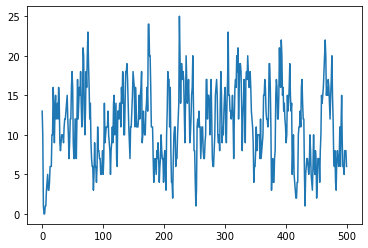

In [39]:
plt.plot(range(len(KTI)),KTI)
plt.show()

In [33]:
import seaborn as sns

In [ ]:
sns.lineplot()

In [68]:
k = len(Tasks)

In [69]:
def show(log,stt):
    plt.figure(figsize=(10, 50))
    for i in range(k):
        name = str(Tasks[i].NUM_NODE) + ' x '+ str(Tasks[i].NUM_DOMAIN)
        plt.subplot(12,2,i+1)
        best = log[:,i].min()
        plt.plot(log[:,i])
        plt.title('IDPCU {i} best: {best}'.format(i=name.upper(),best=best))
    plt.show()

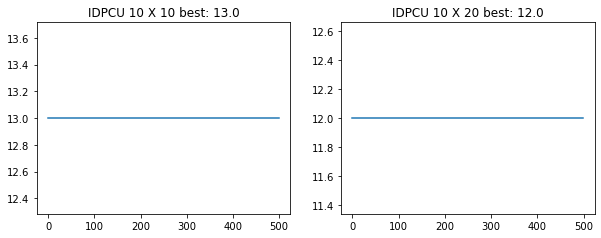

In [70]:
show(log,'30epochs')